In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import splev, splrep
from scipy.io import loadmat
from scipy.signal import kaiserord, firwin, lfilter
import scipy.io as sio
import os
from scipy.io import loadmat
import random
import scipy
import json
from scipy.signal import welch
import math
import sklearn.preprocessing
import sklearn
import seaborn as sns
from scipy.stats import shapiro
from scipy.stats import norm
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

## 0.5 FUNCTION DEFINITION

In [2]:
def hyper_parameters_search_c(clf,train_set, param_grid, scorer = 'accuracy', cv=5):
    results_list = []
    param_list = []
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = "accuracy")
    for validation in range(0, cv):
        train_train_set, val_set = cross_val_automated(train_set) #FUNCIÓN DE OBTENER TRAIN Y VALIDATION
        X_train = train_train_set.iloc[:, [3,6,7]]
        print(X_train)
        y_train = train_train_set.iloc[:,4]
        y_train = y_train.astype(int)
        grid.fit(X_train, y_train)
        results_list.append(grid.best_score_)
        param_list.append(grid.best_params_)
    return results_list, param_list
def hyper_parameters_search(clf, X, y, param_grid, scorer = 'f1', cv=5):
    
    grid = GridSearchCV(clf, param_grid = param_grid, scoring = scorer, cv = cv)
    grid.fit(X, y)

    print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
    print("best parameters: {}".format(grid.best_params_))
    
    return grid

def plot_cv_scoring(grid, hyper_parameter, scorer, plot_errors = False, log=False):
    
    scores = np.array(grid.cv_results_['mean_test_score'])

    std_scores = grid.cv_results_['std_test_score']
        
    params = grid.param_grid[hyper_parameter]
    print(params)

    
    if log:
        params = np.log10(params)
    
    if plot_errors:
        plt.errorbar(params,scores,yerr=std_scores, fmt='o-',ecolor='g')
    else:
        print(len(params))
        print(len(scores))
        print(scores)
        plt.plot(params,scores, 'o-')
    plt.title("Results for each" + hyper_parameter +"value in " + scorer)
    plt.xlabel(hyper_parameter,fontsize=14)
    plt.ylabel(scorer)
    plt.show()
def plot_variance_threshold(X_train, variances, threshold, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(variances)), variances, color='blue', label='Variance')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Variance threshold')
    plt.xticks(range(len(variances)), [f"{i}"for i in feature_names])
    plt.xticks(rotation='vertical')
    plt.title('Variance of each feature with the threshold')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()

from sklearn.metrics import confusion_matrix, roc_curve, auc

def get_metrics(confmat):
    '''Unravel confusion matrix and calculate performance metrics'''
    tn, fp, fn, tp = confmat.ravel()
    
    acc = (tp+tn)/(tn + fp + fn + tp)
    sen = tp/(tp+fn)
    esp = tn/(tn+fp)
    ppv = tp/(tp+fp)
    fsc = 2*(sen*ppv)/(sen+ppv)
    
    return acc, sen, esp, ppv, fsc
    
def print_performance_metrics(confmat_train, *confmat_test):
    '''Print performance metrics'''
    
    if not confmat_test:
        acc, sen, esp, ppv, fsc = get_metrics(confmat_train)
        print('ACC: %2.2f' %(100*acc))
        print('SEN: %2.2f' %(100*sen))
        print('ESP: %2.2f' %(100*esp))
        print('PPV: %2.2f' %(100*ppv))
        print('F1: %2.2f' %(100*fsc))
    else:
        acc_train, sen_train, esp_train, ppv_train, fsc_train = get_metrics(confmat_train)
        acc_test, sen_test, esp_test, ppv_test, fsc_test = get_metrics(confmat_test[0])
        metrics = [acc_train, sen_train, esp_train, ppv_train, fsc_train,acc_test, sen_test, esp_test, ppv_test, fsc_test]
        
        print('PERFORMANCE METRICS')
        print('\tTRAIN\tTEST')
        print('ACC:\t%2.2f\t%2.2f' %(100*acc_train, 100*acc_test))
        print('SEN:\t%2.2f\t%2.2f' %(100*sen_train, 100*sen_test))
        print('ESP:\t%2.2f\t%2.2f' %(100*esp_train, 100*esp_test))
        print('PPV:\t%2.2f\t%2.2f' %(100*ppv_train, 100*ppv_test))
        print('F1:\t%2.2f\t%2.2f'  %(100*fsc_train, 100*fsc_test))
        
        return metrics
        
def plot_roc_curve(y,y_prob):
    
    '''Plot ROC-AUC Curve and target probability'''
    
    ejex, ejey, _ = roc_curve(y, y_prob)
    roc_auc = auc(ejex, ejey)

    plt.figure(figsize = (12,4))
    
    # ROC-AUC CURVE
    plt.subplot(1,2,1)
    plt.plot(ejex, ejey, color='darkorange',lw=2, label='AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color=(0.6, 0.6, 0.6), linestyle='--')
    plt.plot([0, 0, 1],[0, 1, 1],lw=2, linestyle=':',color='black',label='Perfect classifier')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR (1-ESP)')
    plt.ylabel('SEN')
    plt.legend(loc="lower right")
    
    # PROB DENSITY 
    idx_0 = (y==0)
    idx_1 = (y==1)
    
    plt.subplot(1,2,2)
    plt.hist(y_prob[idx_0],density=1,bins = 20, label='y=0',alpha=0.5)
    plt.hist(y_prob[idx_1],density=1,bins = 20, facecolor='red',label='y=1',alpha=0.5)
    plt.legend()
    plt.xlabel('target probability')
    
    plt.show()
    return roc_auc

def plot_confusion_matrix(confmat_train, *confmat_test):
    ''' Plot confusion matrix
        - A single confusion matrix
        - Comparing two confusion matrices, if provided
    '''
    
    if not confmat_test:
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax.text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        plt.xlabel('predicted label')
        plt.ylabel('true label')

        plt.tight_layout()
        plt.show()
        
    else:
        fig, ax = plt.subplots(1,2,figsize=(6, 6))
        ax[0].matshow(confmat_train, cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_train.shape[0]):
            for j in range(confmat_train.shape[1]):
                ax[0].text(x=j, y=i, s=confmat_train[i, j], va='center', ha='center')

        ax[1].matshow(confmat_test[0], cmap=plt.cm.Blues, alpha=0.5)
        for i in range(confmat_test[0].shape[0]):
            for j in range(confmat_test[0].shape[1]):
                ax[1].text(x=j, y=i, s=confmat_test[0][i, j], va='center', ha='center')
    
        ax[0].set_xlabel('predicted label')
        ax[0].set_ylabel('true label')
        ax[0].set_title('TRAIN')
        
        ax[1].set_xlabel('predicted label')
        ax[1].set_ylabel('true label')
        ax[1].set_title('TEST')

        plt.tight_layout()
        plt.show()

def analyze_train_test_performance(clf, X_train, X_test, y_train, y_test):
    
    '''Analyze Train and Test Performance'''
    
    # get predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test  = clf.predict(X_test)
    
    # get confusion matrices
    confmat_train = confusion_matrix(y_train, y_pred_train)
    confmat_test  = confusion_matrix(y_test, y_pred_test)
    
    # Plot confusion matrices and provide metrics
    metrics = print_performance_metrics(confmat_train, confmat_test)
    plot_confusion_matrix(confmat_train, confmat_test)

    # Plot ROC curve
    y_prob = clf.predict_proba(X_test)[:,1]
    print(type(y_prob))
    roc_auc = plot_roc_curve(y_test,y_prob)
    
    return metrics, roc_auc
    
def crossval_curves(model, X, y, param_name, scorer, param_range):
    train_scores, validation_scores = validation_curve(model, X, y, param_name=param_name, scoring=scorer, param_range=param_range)

    # Plot the mean train error and validation error across folds
    plt.figure(figsize=(6, 4))
    plt.plot(param_range, validation_scores.mean(axis=1), lw=2, label='Validation', marker='o')
    plt.plot(param_range, train_scores.mean(axis=1), lw=2, label='Train',marker='*')
    plt.legend(loc='best')
    plt.xlabel(param_name)
    plt.ylabel(scorer)
    plt.title('Validation curve')
    plt.tight_layout()
    plt.show()
def learning_by_samples(model, X, y, scorer, train_sizes, cv=5):
    train_sizes, train_scores, validation_scores = learning_curve(model, X, y, train_sizes=train_sizes, cv=cv, scoring=scorer)

    # Plot the mean train error and validation error across train_sizes
    plt.figure(figsize=(6, 4))
    plt.plot(train_sizes, validation_scores.mean(axis=1), lw=2, label='Validation', marker='o')
    plt.plot(train_sizes, train_scores.mean(axis=1), lw=2, label='Train', marker='*')
    plt.legend(loc='best')
    plt.xlabel('Train Sizes')
    plt.ylabel(scorer)
    plt.title('Learning Curve')
    plt.tight_layout()
    plt.show()
def cross_val_automated(X):
    """X is a df"""
    pacientes_unicos = X['Pacient_id'].unique()
    contador = 0

    # Hacer el split paciente por paciente
    while contador == 0:
        pacientes_train, pacientes_val = train_test_split(pacientes_unicos, test_size=0.1) 
        # Crear conjuntos de entrenamiento y prueba basados en los identificadores de los pacientes
        train_set = X[X['Pacient_id'].isin(pacientes_train)]
        val_set = X[X['Pacient_id'].isin(pacientes_val)]
        if train_set.shape[0] in range(round(val_set.shape[0] * 8), val_set.shape[0] * 10):
            contador = 1

    # Verificar que no haya pacientes compartidos entre train y test
    pacientes_compartidos = set(pacientes_train) & set(pacientes_val)
    if len(pacientes_compartidos) == 0:
        print("¡No hay pacientes compartidos entre train y test!")
    else:
        print("Hay pacientes compartidos entre train y test")
        
    return train_set, val_set
def plot_variance_threshold(X_train, variances, threshold, feature_names):
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(variances)), variances, color='blue', label='Variance')
    plt.axhline(y=threshold, color='red', linestyle='--', label='Variance threshold')
    plt.xticks(range(len(variances)), [f"{i}"for i in feature_names])
    plt.xticks(rotation='vertical')
    plt.title('Variance of each feature with the threshold')
    plt.xlabel('Features')
    plt.ylabel('Variance')
    plt.legend()
    plt.show()


## 1. OPENING DATAFRAME

In [3]:
df_cargado = pd.read_pickle('/kaggle/input/dataset-alternants-ampl/DATASET_ALTERNATS_FINAL_AMPL.pkl')
df_cargado2 = pd.read_pickle('/kaggle/input/dataframe-alternats/DATASET_ALTERNATS_FINAL.pkl')
df = df_cargado
df_30 = df_cargado2

## 2. FEATURE OBTENTION

### 2.1 FUNCTIONS 

In [4]:
def TimeMethod_TWA(M_Wind):
    """
    This function applies the Time Method to detect TWA, as reported in:

    MG Fernández-Calvillo et all, "Machine Learning approach for TW detection relying on ensemble data design," Heliyon, Vol.9, No. 1, Jan 2023.

    Parameters:
        M_Wind (array): Array containing the signal corresponding to one window of ST-ST complexes.

    Returns:
        Valt_est (float): Estimated TWA voltage (in microV).
        Valt_wave_est (array): ML estimate of the alternant wave (in microV).
    """

    M_Wind = np.array(M_Wind)  # Convert the list to a NumPy array


    Valt_wave_est = np.mean(M_Wind[::2, :], axis=0) - np.mean(M_Wind[1::2, :], axis=0)
    Valt_est = np.max(np.abs(Valt_wave_est)) * 0.5 * 1e3   #El 1e3 es para pasar a mV

    return Valt_est, Valt_wave_est
def SM_TWA(M_Wind):  #El espectro se calcula con las columnas
    """
    This function applies the enhanced spectral method (SM) explained in:

    MG Fernández-Calvillo et all, "Machine Learning approach for TWA detection relying on ensemble data design," Heliyon, Vol. 9, no. 1, Jan 2023.

    The method can work over either ST-T complexes or differential ST-T complexes. The SM estimates the power spectrum density of each beat
    series Sj by means of the periodogram:

             Pj=(1/M)|FFT({Sj})|^2

    where M stands for the number of heartbeats taken to apply the SM. The averaged power spectrum of the all beat series is:

                 P=(1/N)?Pj

    Parameters:
        M_Wind (array): Array containing the signal corresponding to one window.

    Returns:
        AverPSD (array): Averaged spectrum.
        K_score (float): TWAR value.
        Valt (float): Estimated alternant wave.
    """

    M = len(M_Wind)#['0'])
    N = len(M_Wind[0])#['0'][0])

    L = 2 ** np.ceil(np.log2(M))  # Resolution of the FFT.


    PSD_BeatSeries = np.abs(np.fft.fft(M_Wind, L, axis=0)) ** 2
    AverPSD = np.mean(PSD_BeatSeries, axis=1) / (M * N)

    noise_band = AverPSD[int(0.66 * ((L / 2)-1)):int(0.96 * ((L / 2)-1))]


    noise_mean = np.mean(noise_band)

    noise_std = np.std(noise_band)

    T = AverPSD[1 + int(((L / 2)-1))]

    K_score = (T - noise_mean) / noise_std

    if K_score > 0:
        Valt = np.sqrt(T - noise_mean) / np.sqrt(M)  # The division by sqrt(M) is to compensate a weighting factor.
    else:
        Valt = 0



    return AverPSD, K_score, Valt, PSD_BeatSeries
def standard_deviation(SEGMENT):
    """WE EXPECT TO HAVE HIGHER STANDARD DEVIATION IN THE ST SEGMENTS WITH ALTERNANTS THAN WITHOUT IT"""
    std = np.std(np.mean(SEGMENT.T, axis = 0))
    return std
def calculate_rms(SEGMENT):
    """
    Calculate Root Mean Square (RMS) of a set of values.

    Parameters:
    - values: numpy array or list, input values

    Returns:
    - rms: float, root mean square
    """
    rms = np.sqrt(np.mean(np.mean(SEGMENT.T, axis = 0)**2))
    return rms
def higher_peack(PSD):
    Peacks = []
    for element in PSD:
        Peacks.append(np.max(element))
    return np.mean(Peacks)
def cusum_detect_change(series):
    n = len(series)
    
    mean = np.mean(series)
    
    cusum = np.cumsum(series - mean)
    
    threshold = 1.96 * np.std(series)

    change_points = np.where(np.abs(cusum) > threshold)[0]

    return change_points

### 2.2 CREATION OF DF WITH THE FEATURES

#### 2.2.1 K-SCORE

In [5]:
for name, block in df["SEGMENT"].items():   #We iterate thourghout the segments of our dataset
    AverPSD, K_score, Valt,_ = SM_TWA(block)
    #Calculate the spectral entropy
    #spectral_entropy = get_spectral_entropy_value(AverPSD)

    df.at[str(name), 'K-SCORE'] = K_score
    #df.at[str(name), "Spectral-entropy"] = spectral_entropy
for name, block in df_30["SEGMENT"].items():   #We iterate thourghout the segments of our dataset
    AverPSD, K_score, Valt,_ = SM_TWA(block)
    #Calculate the spectral entropy
    #spectral_entropy = get_spectral_entropy_value(AverPSD)

    df_30.at[str(name), 'K-SCORE'] = K_score
    #df.at[str(name), "Spectral-entropy"] = spectral_entrop

In [6]:
df

,Pacient_id,fs,SEGMENT,K-SCORE,label,V_alt_wave
Name,,,,,,
edb_106_l1_s1.mat_segment_0,106,250,"[[-0.024926062570195095, -0.02822712305287149,...",1.575711,1,29.0
edb_106_l1_s1.mat_segment_1,106,250,"[[0.022370628252533987, 0.024978833285478574, ...",4.461907,1,29.0
edb_106_l1_s1.mat_segment_2,106,250,"[[-0.01973526070451536, -0.02284479699702847, ...",5.720453,1,29.0
edb_106_l1_s1.mat_segment_3,106,250,"[[-0.022201919252025863, -0.026605056421908645...",3.101704,1,29.0
edb_106_l1_s1.mat_segment_4,106,250,"[[0.022550210051446924, 0.025844851559693738, ...",6.752279,1,29.0
...,...,...,...,...,...,...
nsrdb_19140_l2_s9.mat_segment_182,19140,128,"[[0.021601179974117375, 0.027383825191435493, ...",-0.876823,0,0.0
nsrdb_19140_l2_s9.mat_segment_183,19140,128,"[[-0.01622616571431188, -0.021882371527206373,...",-1.628666,0,0.0
nsrdb_19140_l2_s9.mat_segment_184,19140,128,"[[-0.0023253653690870294, -0.00416981924359499...",-1.958226,0,0.0


#### 2.2.2 V_alt

In [7]:
for name, block in df["SEGMENT"].items():
    #print(name)
    V_alt, _ = TimeMethod_TWA(block)
    df.at[str(name), 'V_alt'] = V_alt
for name, block in df_30["SEGMENT"].items():
    #print(name)
    V_alt, _ = TimeMethod_TWA(block)
    df_30.at[str(name), 'V_alt'] = V_alt

KeyboardInterrupt: 

In [ ]:
df

#### 2.2.3 CUSUM

In [ ]:
for name, row in df.iterrows():
    SEGMENT = row["SEGMENT"]
    fs = row["fs"]
    _, psd = welch(SEGMENT.T, fs, window = "hamming", nperseg=31)
    mean_psd = np.mean(psd, axis = 0)
    cusum_list = cusum_detect_change(mean_psd) #Get the cusum list of lists
    if 14 in cusum_list:
        df.at[str(name), 'CUSUM'] = 1
    else:
        df.at[str(name), 'CUSUM'] = 0
for name, row in df_30.iterrows():
    SEGMENT = row["SEGMENT"]
    fs = row["fs"]
    _, psd = welch(SEGMENT.T, fs, window = "hamming", nperseg=31)
    mean_psd = np.mean(psd, axis = 0)
    cusum_list = cusum_detect_change(mean_psd) #Get the cusum list of lists
    if 14 in cusum_list:
        df_30.at[str(name), 'CUSUM'] = 1
    else:
        df_30.at[str(name), 'CUSUM'] = 0
df

#### 2.2.4 STD and RMS

In [ ]:
for name, block in df["SEGMENT"].items():
    #GET STANDARD DEVIATION AND ROOT MEAN SQUARE
    STD = standard_deviation(block)
    RMS = calculate_rms(block)
    
    
    
    df.at[str(name), 'STD'] = STD
    df.at[str(name), 'RMS'] = RMS
for name, block in df["SEGMENT"].items():
    #GET STANDARD DEVIATION AND ROOT MEAN SQUARE
    STD = standard_deviation(block)
    RMS = calculate_rms(block)
    
    
    
    df_30.at[str(name), 'STD'] = STD
    df_30.at[str(name), 'RMS'] = RMS
df

#### 2.2.5 PEAK in 0.5 freq

In [ ]:
for name, row in df.iterrows():
    #GET PEAK FREQ
    SEGMENT = row["SEGMENT"]
    fs = row["fs"]
    _, psd = welch(SEGMENT.T, fs, window = "hamming", nperseg=31)
    mean_psd = np.mean(psd, axis = 0)
    new = mean_psd[-1]
    
    df.at[str(name), 'PEACK'] = new
for name, row in df_30.iterrows():
    #GET PEAK FREQ
    SEGMENT = row["SEGMENT"]
    fs = row["fs"]
    _, psd = welch(SEGMENT.T, fs, window = "hamming", nperseg=31)
    mean_psd = np.mean(psd, axis = 0)
    new = mean_psd[-1]
    
    df_30.at[str(name), 'PEACK'] = new

In [ ]:
df

## 3. CREATION OF ML ALGORITHMS

In [ ]:
feature_names_total = ["K-SCORE", "V_alt", "CUSUM","STD", "RMS", "PEACK"]

In [ ]:
#Split the dataset into training and test
from sklearn.model_selection import train_test_split
contador = 0

# Obtener una lista de todos los pacientes únicos
pacientes_unicos = df['Pacient_id'].unique()

# Hacer el split paciente por paciente
while contador == 0:
    pacientes_train, pacientes_test = train_test_split(pacientes_unicos, test_size=0.3)
    # Crear conjuntos de entrenamiento y prueba basados en los identificadores de los pacientes
    train_set = df[df['Pacient_id'].isin(pacientes_train)]
    test_set = df[df['Pacient_id'].isin(pacientes_test)]
    if train_set.shape[0] in range(round(test_set.shape[0] * 2.7), test_set.shape[0] * 3):
        contador = 1

# Verificar que no haya pacientes compartidos entre train y test
pacientes_compartidos = set(pacientes_train) & set(pacientes_test)
if len(pacientes_compartidos) == 0:
    print("¡No hay pacientes compartidos entre train y test!")
else:
    print("Hay pacientes compartidos entre train y test")

# Ahora 'train_set' y 'test_set' contienen todas las instancias de los pacientes respectivos

In [51]:
train_set.to_pickle('/kaggle/working/train_set.pkl')
test_set.to_pickle('/kaggle/working/test_set.pkl')

In [8]:
train_set = pd.read_pickle("/kaggle/input/training-test-set/train_set(1).pkl")
test_set = pd.read_pickle("/kaggle/input/training-test-set/test_set(1).pkl")

In [6]:
print(test_set.shape)
print(train_set.shape)
print(df.shape)

(35899, 11)
(100589, 11)
(136488, 6)


In [9]:
train_set

,Pacient_id,fs,SEGMENT,K-SCORE,label,V_alt_wave,V_alt,CUSUM,STD,RMS,PEACK
Name,,,,,,,,,,,
edb_106_l1_s1.mat_segment_0,106,250,"[[-0.024926062570195095, -0.02822712305287149,...",1.575711,1,29.0,14.857235,0.0,0.024312,0.024350,0.000013
edb_106_l1_s1.mat_segment_1,106,250,"[[0.022370628252533987, 0.024978833285478574, ...",4.461907,1,29.0,23.660734,0.0,0.028076,0.028079,0.000028
edb_106_l1_s1.mat_segment_2,106,250,"[[-0.01973526070451536, -0.02284479699702847, ...",5.720453,1,29.0,26.864699,1.0,0.026407,0.026407,0.000045
edb_106_l1_s1.mat_segment_3,106,250,"[[-0.022201919252025863, -0.026605056421908645...",3.101704,1,29.0,26.059766,1.0,0.027336,0.027366,0.000041
edb_106_l1_s1.mat_segment_4,106,250,"[[0.022550210051446924, 0.025844851559693738, ...",6.752279,1,29.0,27.740649,0.0,0.025969,0.025983,0.000019
...,...,...,...,...,...,...,...,...,...,...,...
nsrdb_19140_l2_s9.mat_segment_182,19140,128,"[[0.021601179974117375, 0.027383825191435493, ...",-0.876823,0,0.0,5.641978,0.0,0.013637,0.013639,0.000004
nsrdb_19140_l2_s9.mat_segment_183,19140,128,"[[-0.01622616571431188, -0.021882371527206373,...",-1.628666,0,0.0,2.528227,0.0,0.013214,0.013220,0.000004
nsrdb_19140_l2_s9.mat_segment_184,19140,128,"[[-0.0023253653690870294, -0.00416981924359499...",-1.958226,0,0.0,2.603798,0.0,0.012095,0.012095,0.000006


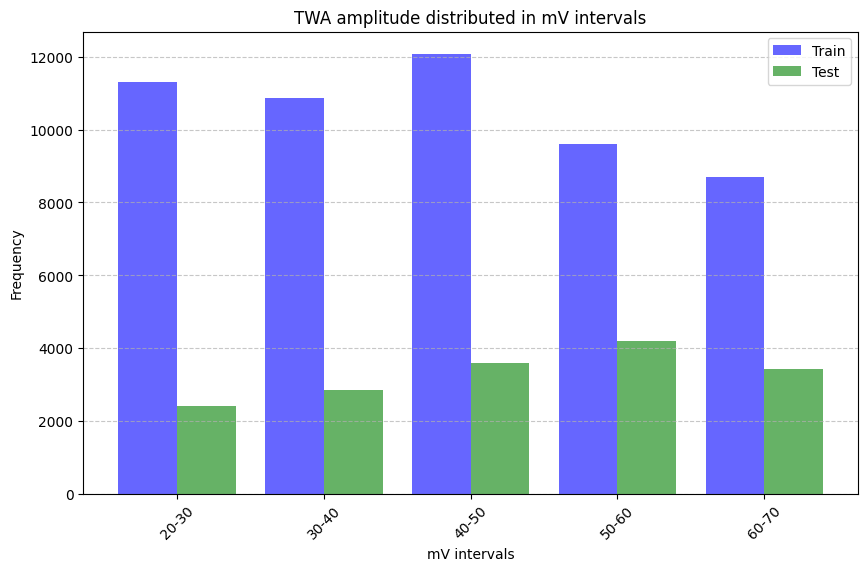

In [19]:
# Definir los intervalos
bins = [20, 30, 40, 50, 60, 70]
labels = ['20-30', '30-40', '40-50', '50-60', '60-70']

# Crear una nueva columna con los intervalos
train_set['interval'] = pd.cut(train_set['V_alt_wave'], bins=bins, labels=labels, right=False)
test_set['interval'] = pd.cut(test_set['V_alt_wave'], bins=bins, labels=labels, right=False)

# Contar los valores en cada intervalo
interval_counts_train = train_set['interval'].value_counts().sort_index()
interval_counts_test = test_set['interval'].value_counts().sort_index()
# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
width = 0.4  # Ancho de las barras

# Desplazar las posiciones de los intervalos
interval_positions = range(len(labels))

# Graficar los datos de entrenamiento y prueba ajustando las posiciones
plt.bar([p - width/2 for p in interval_positions], interval_counts_train, width=width, color='blue', alpha=0.6, label='Train')
plt.bar([p + width/2 for p in interval_positions], interval_counts_test, width=width, color='green', alpha=0.6, label='Test')

# Personalizar el gráfico
plt.title('TWA amplitude distributed in mV intervals')
plt.xlabel('mV intervals')
plt.ylabel('Frequency')
plt.xticks(interval_positions, labels, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Mostrar el gráfico
plt.show()

In [19]:
X_train = train_set.iloc[:, [3,6,7,8,9,10]]
y_train = train_set.iloc[:,4]
y_train = y_train.astype(int)
X_test = test_set.iloc[:, [3,6,7,8,9,10]]
y_test = test_set.iloc[:,4]
y_test = y_test.astype(int)

In [36]:
training_set = pd.concat([X_train, y_train], axis = 1)

### 3.1 FEATURE SELECTION AND CORRELATIONAL ANALYSIS

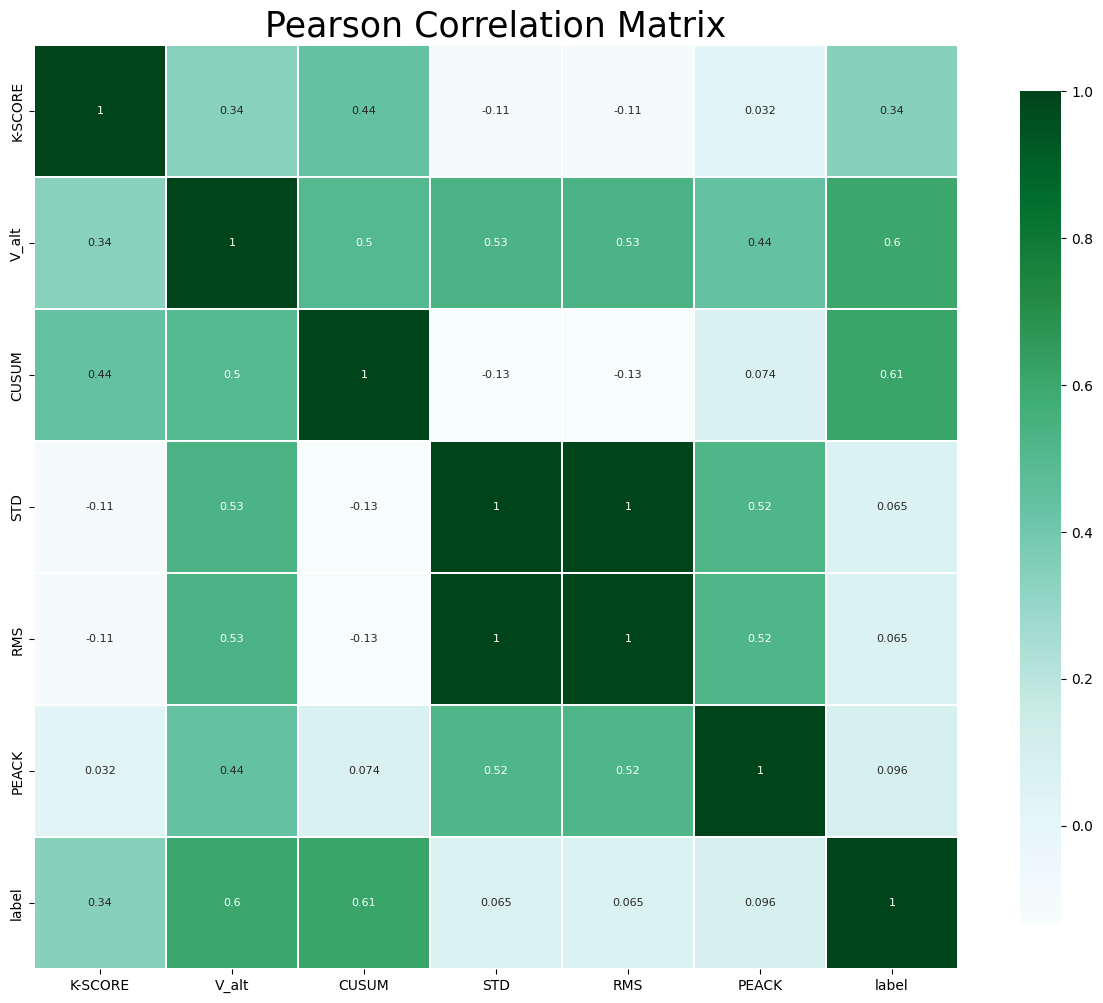

,K-SCORE,V_alt,CUSUM,STD,RMS,PEACK,label
K-SCORE,1.000000,0.340759,0.438933,-0.111356,-0.111440,0.032086,0.341532
V_alt,0.340759,1.000000,0.498738,0.534508,0.534474,0.441092,0.603348
CUSUM,0.438933,0.498738,1.000000,-0.132417,-0.132499,0.074345,0.612209
STD,-0.111356,0.534508,-0.132417,1.000000,0.999998,0.519493,0.065219
RMS,-0.111440,0.534474,-0.132499,0.999998,1.000000,0.519346,0.065167
PEACK,0.032086,0.441092,0.074345,0.519493,0.519346,1.000000,0.096399
label,0.341532,0.603348,0.612209,0.065219,0.065167,0.096399,1.000000


In [21]:
correlation_matrix = training_set.corr()

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix', fontsize=25)
sns.heatmap(correlation_matrix, linewidths=0.25, square=True, cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w', annot=True, annot_kws={"size": 8}, cbar_kws={"shrink": .9})
plt.show()

display(training_set.corr())

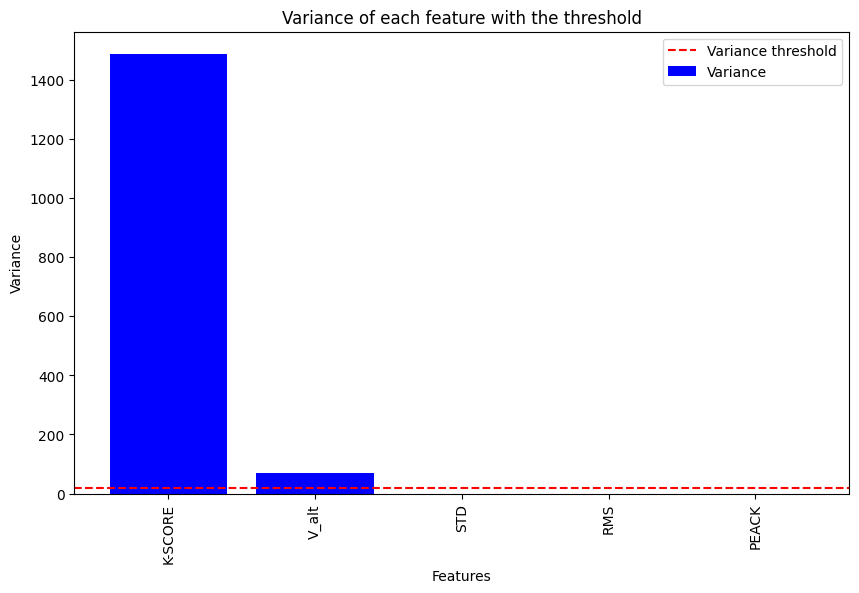

In [22]:
#VARIANCE THRESHOLDING:
features_names_VT = ["K-SCORE", "V_alt","STD", "RMS", "PEACK"]
X_train_VT = train_set.iloc[:, [3,5,7,8,9]]

from sklearn.feature_selection import VarianceThreshold
threshold_value_1 = 20

# Aplicar VarianceThreshold de scikit-learn
selector = VarianceThreshold()
selected_features = selector.fit_transform(X_train_VT)

# Obtener las varianzas
variances = selector.variances_


# Plotear las varianzas junto con el umbral
plot_variance_threshold(X_train_VT, variances, threshold_value_1, features_names_VT)

[512811.77722564]
[0.]


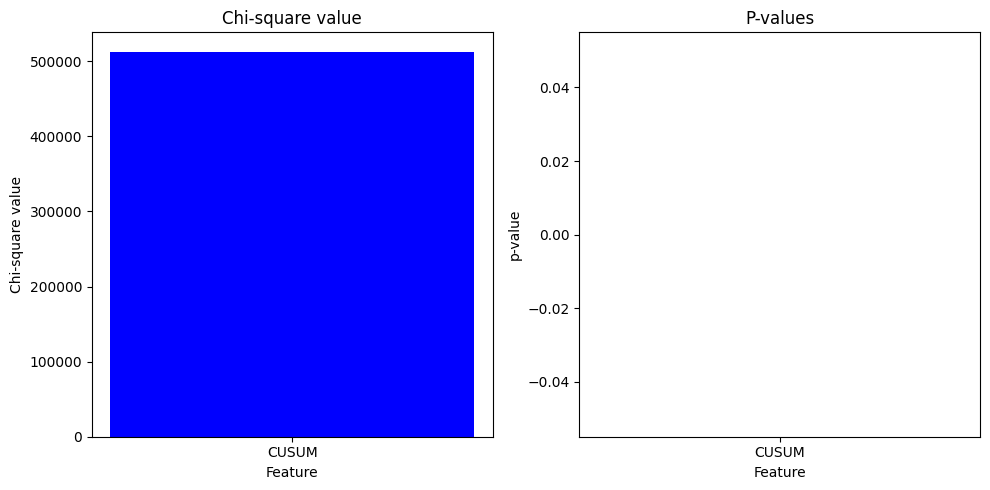

In [23]:
#CHI-SQUARED PARA EL TEMA DE LAS VARIABLES CATEGÓRICAS
from sklearn.feature_selection import chi2
# Calculamos los p-values y los valores de Chi-cuadrado

X_train_chi = train_set.iloc[:, [6]]
chi2_values, p_values = chi2(X_train_chi, y_train)
print(chi2_values)
print(p_values)

# Plotear los valores
plt.figure(figsize=(10, 5))

# Plotear los valores de Chi-cuadrado
plt.subplot(1, 2, 1)
plt.bar("CUSUM", chi2_values, color='blue')
plt.title('Chi-square value')
plt.xlabel('Feature')
plt.ylabel('Chi-square value')

# Plotear los p-values
plt.subplot(1, 2, 2)
plt.bar("CUSUM", p_values, color='green')  # Usamos -log(p-value) para mejor visualización
plt.title('P-values')
plt.xlabel("Feature")
plt.ylabel('p-value')

plt.tight_layout()
plt.show()

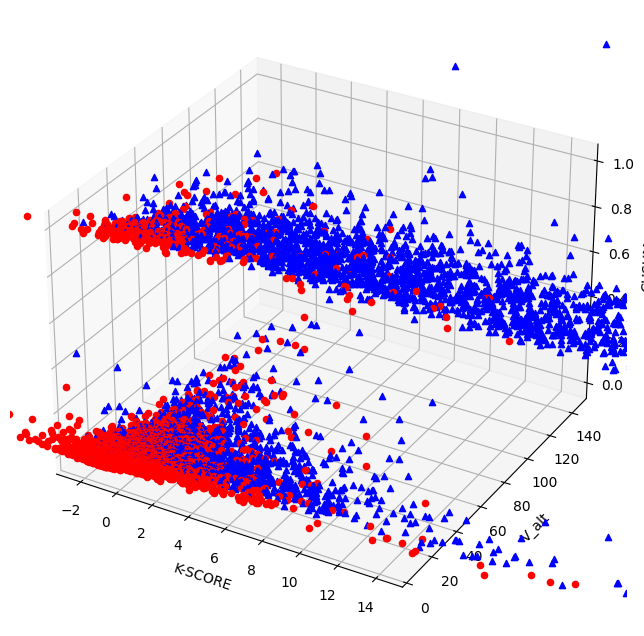

In [47]:
#GRAPH OF THE FEATUERES
# Crear una figura y un eje 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
counter = 0
# Dibujar los puntos en el espacio 3D y colorearlos según el label
for index, row in training_set.sample(frac=1).iterrows():
    if counter < 10000:
        if row['label'] == 0:
            ax.scatter(row["K-SCORE"], row['V_alt'], row['CUSUM'], c='r', marker='o')
        else:
            ax.scatter(row['K-SCORE'], row['V_alt'], row['CUSUM'], c='b', marker='^')
        counter +=1
    else:
        break

# Etiquetas de los ejes
ax.set_xlabel('K-SCORE')
ax.set_ylabel('V_alt')
ax.set_zlabel('CUSUM')

ax.set_xlim(-3, 15)
ax.set_ylim(0, 150)

plt.show()

## 3.2 MACHINE LEARNING ALGORITHMS

In [15]:
#After the correlational and feature selection analysis:
X_train = train_set.iloc[:, [3,6,7]]
y_train = train_set.iloc[:,4]
y_train = y_train.astype(int)
X_test = test_set.iloc[:, [3,6,7]]
y_test = test_set.iloc[:,4]
y_test = y_test.astype(int)

In [11]:
X_train

,K-SCORE,V_alt,CUSUM
Name,,,
edb_106_l1_s1.mat_segment_0,1.575711,14.857235,0.0
edb_106_l1_s1.mat_segment_1,4.461907,23.660734,0.0
edb_106_l1_s1.mat_segment_2,5.720453,26.864699,1.0
edb_106_l1_s1.mat_segment_3,3.101704,26.059766,1.0
edb_106_l1_s1.mat_segment_4,6.752279,27.740649,0.0
...,...,...,...
nsrdb_19140_l2_s9.mat_segment_182,-0.876823,5.641978,0.0
nsrdb_19140_l2_s9.mat_segment_183,-1.628666,2.528227,0.0
nsrdb_19140_l2_s9.mat_segment_184,-1.958226,2.603798,0.0


class 0: (47193, 4)
class 1: (53396, 4)


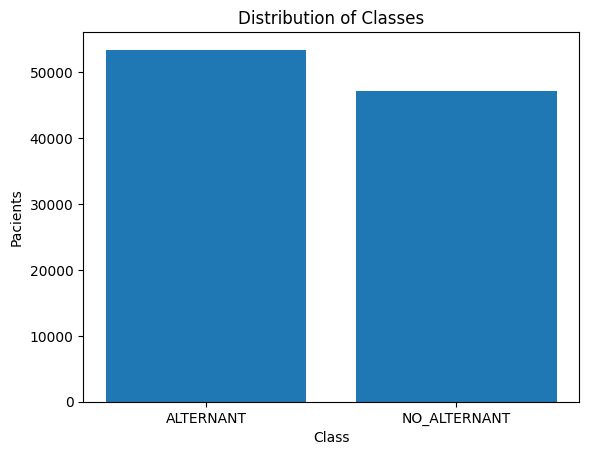

In [12]:
feature_names = ["K-SCORE", "V_ALT", "CUSUM"]
#class distribution
training_dataset = pd.concat([X_train, y_train], axis = 1)
class_count_0, class_count_1 = training_dataset['label'].value_counts()

# Separate class
class_0 = training_dataset[training_dataset['label'] == 0]
class_1 = training_dataset[training_dataset['label'] == 1]
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)


plt.bar(['ALTERNANT', 'NO_ALTERNANT'], [class_count_0, class_count_1])
plt.xlabel('Class')
plt.ylabel('Pacients')
plt.title('Distribution of Classes')
plt.show()

### 3.2.1 LOGISTIC REGRESSION

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
# Logistic regression
regressor1 = LogisticRegression(solver = "liblinear", penalty = "l2") #The solver is added for optimization
# Train the model using the training data
classifier = regressor1.fit(X_train, y_train)
# Show the intercept
intercept = classifier.intercept_
# Show the coefficients
coefficients = classifier.coef_
print(coefficients)  #El que corresponda al mayor inidica que feature ha tenido mayor importancia en el proceso
# Compute the predicted values for the test set
y_pred1 = classifier.predict(X_test)
y_prob_pred1= classifier.predict_proba(X_test)
#  Compute the confusion matrix
cm1 = confusion_matrix(y_test, y_pred1)
print("Confusion Matrix:")
print(cm1)
tp = cm1[1, 1]
fp = cm1[0, 1]
tn = cm1[0, 0]
fn = cm1[1, 0]

print(f'tn: {tn}, fp:{fp}, fn:{fn}, tp:{tp}')

# Compute the accuracy 

Accuracy = accuracy_score(y_test, y_pred1)
print(f'Accuracy: {Accuracy}')

              
#Sensibility
Sensitivity = recall_score(y_test, y_pred1)

print(f'Sensitivity: {Sensitivity}')

Specificity = tn / (tn + fp)
print("Specificity: ", Specificity)

[[0.29832576 0.07689738 0.63711179]]
Confusion Matrix:
[[16926  2078]
 [ 1484 15411]]
tn: 16926, fp:2078, fn:1484, tp:15411
Accuracy: 0.900777180422853
Sensitivity: 0.9121633619414028
Specificity:  0.8906545990317828


PERFORMANCE METRICS
	TRAIN	TEST
ACC:	86.48	90.08
SEN:	83.15	91.22
ESP:	90.25	89.07
PPV:	90.61	88.12
F1:	86.72	89.64


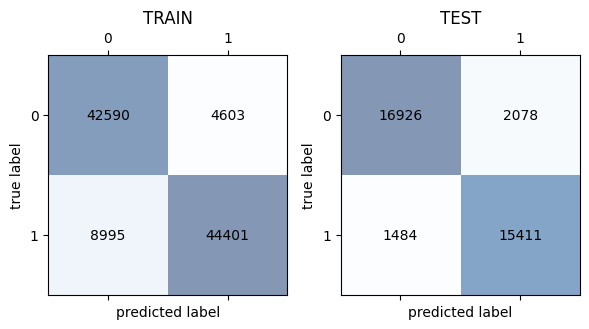

<class 'numpy.ndarray'>


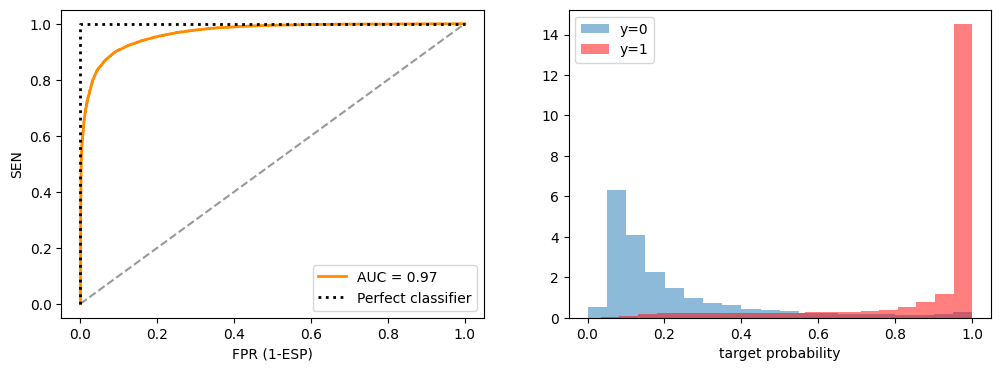

In [14]:
metrics,roc = analyze_train_test_performance(classifier,X_train,X_test,y_train,y_test)

['K-SCORE', 'V_ALT', 'CUSUM']
[0.29832576 0.07689738 0.63711179]


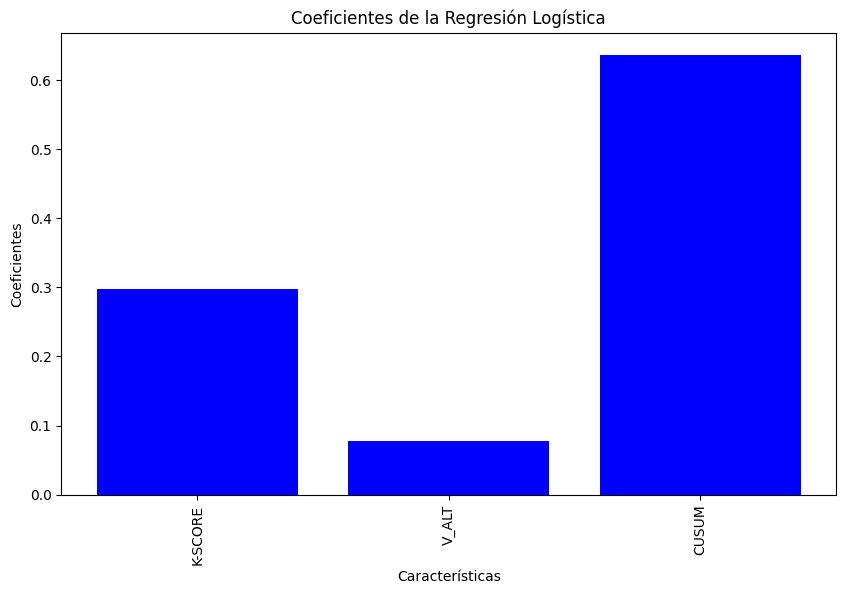

In [15]:
plt.figure(figsize=(10, 6))
lista = []
for feature in feature_names:
    lista.append(feature)
print(lista)
print(coefficients[0])
    
plt.bar(lista, coefficients[0], color='blue')
plt.xlabel('Características')
plt.ylabel('Coeficientes')
plt.title('Coeficientes de la Regresión Logística')
plt.xticks(rotation='vertical');

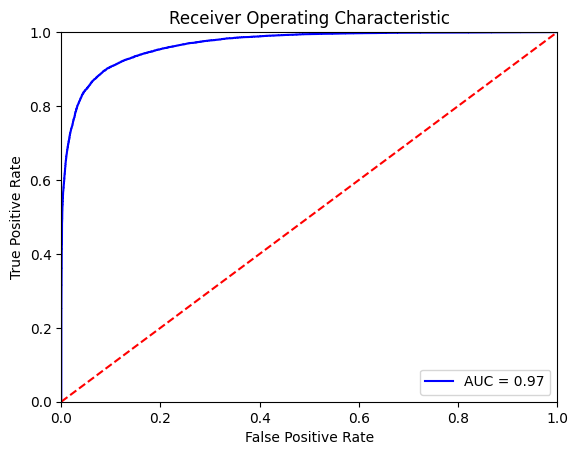

In [16]:
# Compute the AUC and the ROC
from sklearn.metrics import roc_auc_score
fpr, tpr, thresholds = roc_curve(y_test, y_prob_pred1[:, 1])
auc = roc_auc_score(y_test, y_prob_pred1[:, 1])
#ADD RESULTS TO DF

# Plot the ROC curve
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### 3.2.2 DECISION TREE

best mean cross-validation score: 0.858
best parameters: {'min_samples_leaf': 5029}
[5029, 25147, 50294]


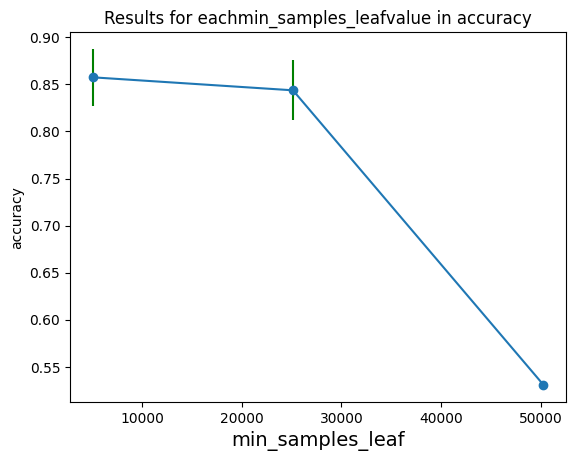

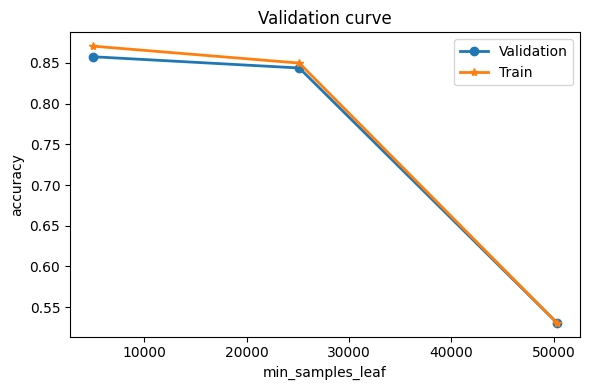

In [17]:
#To apply the rule of thumb it is necessary to partition our training set into small samples of different quantities.
split1 = 0.05
split2 = 0.25
split3 = 0.5
#Now we multiply the split sizes by the total training data.
training_size = X_train.shape[0]
#We need to round them to have a valid value of min samples per leaf
ideal1 = int(round(split1 * training_size, 0))
ideal2 = int(round(split2 * training_size, 0))
ideal3 = int(round(split3 * training_size, 0))
from sklearn.tree import DecisionTreeClassifier
dtclassifier = DecisionTreeClassifier()  #Build the classifier
# Decision trees
param_grid_dt = {'min_samples_leaf': [ideal1, ideal2, ideal3]}

scorer1 = 'accuracy'    #Since our classes are balanced we can use this a performance metric

#HYPER PARAMETER SEARCH WITH CROSS VALIDATION TO PREVENT THE OVERFITTING
grid_dt = hyper_parameters_search(dtclassifier,X_train,y_train, param_grid_dt, scorer = scorer1, cv=5)


# do the plotting
plot_cv_scoring(grid_dt,'min_samples_leaf',scorer1, plot_errors=True)


crossval_curves(dtclassifier, X_train, y_train, "min_samples_leaf", scorer1, [ideal1, ideal2, ideal3])

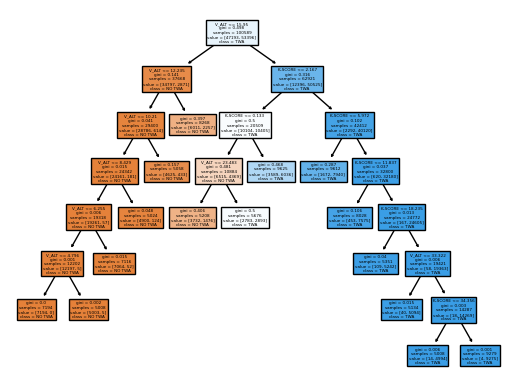

In [18]:
from sklearn.tree import plot_tree
#Firslty we need to define our decision tree model
dt_model = DecisionTreeClassifier(min_samples_leaf = 5008, criterion = "entropy").fit(X_train,y_train)
# set plot dimensions


plot_tree(
    dt_model,
    feature_names=feature_names, 
    class_names=["NO TWA", "TWA"],
    filled=True
)

plt.show()

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	87.07	86.87
SEN:	91.86	96.40
ESP:	81.64	78.41
PPV:	84.99	79.88
F1:	88.29	87.36


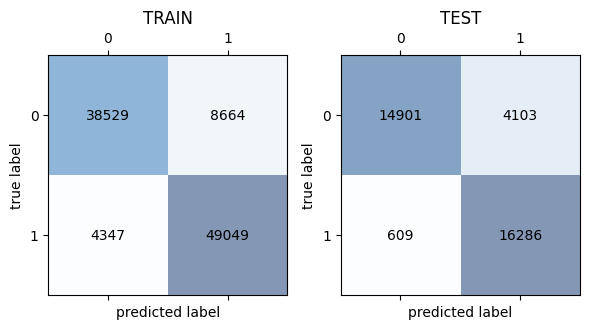

<class 'numpy.ndarray'>


TypeError: 'numpy.float64' object is not callable

In [19]:
metrics,roc = analyze_train_test_performance(dt_model,X_train,X_test,y_train,y_test)
print(metrics)
print(roc)
learning_by_samples(dt_model, X_train, y_train, scorer = "accuracy", train_sizes=np.linspace(0.1, 1.0, 20).tolist(), cv=5)

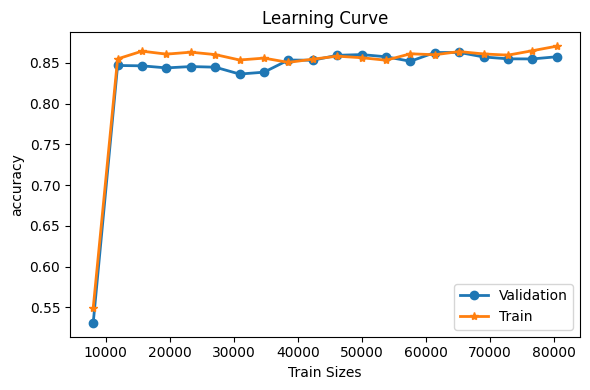

In [20]:
learning_by_samples(dt_model, X_train, y_train, scorer = "accuracy", train_sizes=np.linspace(0.1, 1.0, 20).tolist(), cv=5)

### 3.2.3 RANDOM FOREST

In [22]:
from sklearn.ensemble import RandomForestClassifier
split1 = 0.05
split2 = 0.25
split3 = 0.5
#Now we multiply the split sizes by the total training data.
training_size = X_train.shape[0]
#We need to round them to have a valid value of min samples per leaf
ideal1 = int(round(split1 * training_size, 0))
ideal2 = int(round(split2 * training_size, 0))
ideal3 = int(round(split3 * training_size, 0))
print(ideal1)


5029


In [23]:
from collections import Counter
rf_model =  RandomForestClassifier()
param_grid_rf = {'min_samples_leaf': [ideal1, ideal2, ideal3]}

scorer1 = 'accuracy'    #Since our classes are balanced we can use this a performance metric

#HYPER PARAMETER SEARCH WITH CROSS VALIDATION TO PREVENT THE OVERFITTING
#grid_dt = hyper_parameters_search(rf_model,X_train,y_train, param_grid_dt, scorer = scorer1, cv=5)
results, params = hyper_parameters_search_c(rf_model, train_set , param_grid_rf, scorer = 'accuracy', cv=5)
print("The mean of the results in the cross validaiton is", np.mean(results))
print(params)

min_samples_leaf_values = [d['min_samples_leaf'] for d in params]

# Contar la frecuencia de cada valor
frecuencia = Counter(min_samples_leaf_values)

# Encontrar el valor con la frecuencia máxima
valor_mas_repetido = max(frecuencia, key=frecuencia.get)

# Mostrar el valor más repetido
print("El valor de 'min_samples_leaf' que más se repite es:", valor_mas_repetido)

¡No hay pacientes compartidos entre train y test!
                                    K-SCORE      V_alt  CUSUM
Name                                                         
edb_106_l1_s1.mat_segment_0        1.575711  14.857235    0.0
edb_106_l1_s1.mat_segment_1        4.461907  23.660734    0.0
edb_106_l1_s1.mat_segment_2        5.720453  26.864699    1.0
edb_106_l1_s1.mat_segment_3        3.101704  26.059766    1.0
edb_106_l1_s1.mat_segment_4        6.752279  27.740649    0.0
...                                     ...        ...    ...
nsrdb_19140_l2_s9.mat_segment_182 -0.876823   5.641978    0.0
nsrdb_19140_l2_s9.mat_segment_183 -1.628666   2.528227    0.0
nsrdb_19140_l2_s9.mat_segment_184 -1.958226   2.603798    0.0
nsrdb_19140_l2_s9.mat_segment_185  1.384641   7.832623    0.0
nsrdb_19140_l2_s9.mat_segment_186 -1.640438   3.684779    0.0

[90066 rows x 3 columns]
¡No hay pacientes compartidos entre train y test!
                                    K-SCORE      V_alt  CUSUM
Name  

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	87.08	88.68
SEN:	85.12	92.51
ESP:	89.29	85.28
PPV:	90.00	84.82
F1:	87.49	88.50


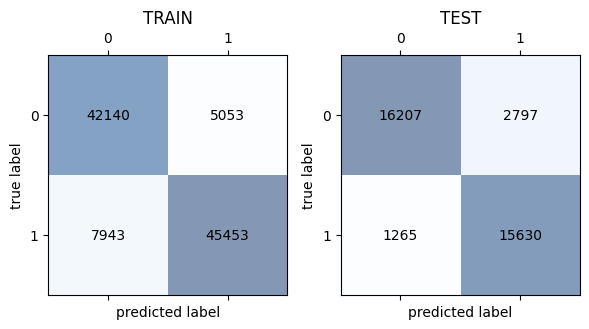

<class 'numpy.ndarray'>


TypeError: 'numpy.float64' object is not callable

In [25]:
rf_model =  RandomForestClassifier(min_samples_leaf = 5029, criterion = "entropy").fit(X_train,y_train)
metrics, roc = analyze_train_test_performance(rf_model,X_train,X_test,y_train,y_test)

### 3.2.4 Support vector machine

In [10]:
from sklearn.svm import SVC

SVM_model = SVC()
#param_grid_SVM = {"kernel":["linear", "poly", "rbf", "sigmoid"]}
param_grid_SVM = {"gamma":["scale", "auto"]}

In [11]:
results, params = hyper_parameters_search_c(SVM_model, train_set , param_grid_SVM, scorer = 'accuracy', cv=5)
print("The mean of the results in the cross validaiton is", np.mean(results))
print(params)

¡No hay pacientes compartidos entre train y test!
                                    K-SCORE      V_alt  CUSUM
Name                                                         
edb_106_l1_s1.mat_segment_0        1.575711  14.857235    0.0
edb_106_l1_s1.mat_segment_1        4.461907  23.660734    0.0
edb_106_l1_s1.mat_segment_2        5.720453  26.864699    1.0
edb_106_l1_s1.mat_segment_3        3.101704  26.059766    1.0
edb_106_l1_s1.mat_segment_4        6.752279  27.740649    0.0
...                                     ...        ...    ...
nsrdb_19140_l2_s9.mat_segment_182 -0.876823   5.641978    0.0
nsrdb_19140_l2_s9.mat_segment_183 -1.628666   2.528227    0.0
nsrdb_19140_l2_s9.mat_segment_184 -1.958226   2.603798    0.0
nsrdb_19140_l2_s9.mat_segment_185  1.384641   7.832623    0.0
nsrdb_19140_l2_s9.mat_segment_186 -1.640438   3.684779    0.0

[90114 rows x 3 columns]


KeyboardInterrupt: 

PERFORMANCE METRICS
	TRAIN	TEST
ACC:	88.19	88.60
SEN:	89.87	94.81
ESP:	86.29	83.07
PPV:	88.12	83.28
F1:	88.98	88.67


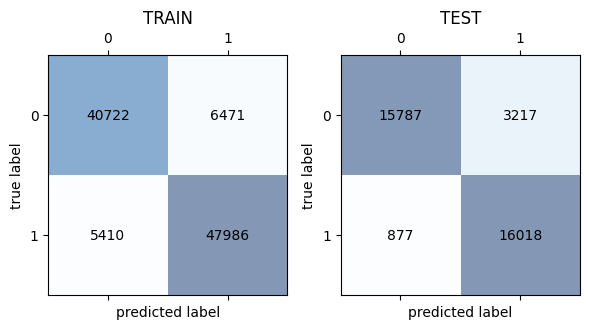

AttributeError: predict_proba is not available when  probability=False

In [16]:
SVM_model =  SVC(kernel = "rbf", gamma = "auto").fit(X_train,y_train)
metrics, roc = analyze_train_test_performance(SVM_model,X_train,X_test,y_train,y_test)